# File Organizer
### Written By: Matthew Oleszko, March 24, 2022
The purpose of this file is organize, analyze, and visualize WIS GPS data.
THE LOCATION OF THIS FILE IS KEY.

The file should be located in a folder that lists all GPS stations. An example would be at the WIS/proc/csrs location.


In [2]:
import numpy as np
import pandas as pd
import os
import glob

In [3]:
def ListStations(printList=True):
    '''
    This function generates a list of all of the subdirectories at the file location
    When the running notebook is located in the WIS/proc/csrs location, the returning
    list will be comprised of the path to each GPS station.
    '''
    
    dirlist = [] #Creates empty list
    for it in os.scandir():  #Loops through all files and directories at the location of the running file
        if it.is_dir():  #Excludes any files that are not directories
            dirlist += [it.path]  #Adds the path to each directory to the dirlist
    if(printList == True):  #If the printList parameter is set to True will print the dirlist
        print(dirlist)
    return dirlist

In [4]:
def CombineStationFiles(stationPath, columnsToKeep = ['YEAR','MM','DD', 'DAYofYEAR', 'LATDD', 'LATMN', 'LATSS', 'LONDD', 'LONMN', 'LONSS', 'HGT(m)'], 
                        save=True):
    '''
    This function will combine all of the .pos files in a station directory into a single Pandas dataframe.
    Parameters:
    stationPath-- parameter should be the path to the station folder. This path can be located using the 
        ListStations function when that is located in the WIS/proc/csrs directory. The stationPath parameter can 
        then be included by referencing the relevant item in the list returned by the ListStations Function.
    columnsToKeep-- parameter is a list of columns that user would like to be stored in the returned dataframe. The 
        column options in the pos files include: 
        DIR FRAME,   STN,   DAYofYEAR,   YEAR-MM-DD,   HR:MN:SS.SS,   NSV,    GDOP,    RMSC(m),    RMSP(m),    DLAT(m),
        DLON(m),       DHGT(m),   CLK(ns),    TZD(m),    SDLAT(95%),     SDLON(95%),     SDHGT(95%),    SDCLK(95%),
        SDTZD(95%),    LATDD,    LATMN,    LATSS,     LONDD,     LONMN,     LONSS,     HGT(m),     UTMZONE,    
        UTM_EASTING,   UTM_NORTHING,     UTM_SCLPNT,     UTM_SCLCBN
        E.G. [YEAR-MM-DD, DAYofYEAR, LATDD, LATMN, LATSS, LONDD, LONMN, LONSS, HGt(m)]
    save-- parameter is set to True, the resulting combined dataframe will be saved as a csv file in the 
        appropriate station directory. After running this function once, the results can be accessed in the future
        using the pandas.read_csv function. 
    '''
    
    
    fileList = glob.glob(stationPath+"/*/*.pos")  #will generate a list of all of the .pos files within a station directory 
                                                  #assuming the directory structure is set up as: stationPath/'Year'/''.pos files'

    widths=[4,6,6,11,4,1,2,1,3,12,4,5,8,14,14,14,17,9,7,11,11,11,11,11,6,6,9,6,6,11,9,11,12,15,11,9]  #character widths of each column in the .pos files
    Stat = pd.read_fwf(fileList[0],header=5,widths=widths)[columnsToKeep]  #imports first .pos file as a 'fixed width file.' The width of each imported file column is described in the widths list
    for i in range(1,len(fileList)):  #loops through remaining files and concatinates data to the bottom of the accumulative dataframe
        Stat = pd.concat([Stat,pd.read_fwf(fileList[i],header=5,widths=widths)[columnsToKeep]])
    Stat = Stat.sort_values(by=['YEAR','DAYofYEAR'])  #Sorts the list first considering YEAR then decimal DAYofYEAR
    Stat = Stat.reset_index(drop=True)  #Resets the Pandas dataframe index's
    
    if save==True:  #If save parameter is set to true, will save accumulative dataframe as a csv in the station directory
        Stat.to_csv(stationPath+'\\Cumulative.csv')
    return Stat

In [49]:
def CalculateDistance(dataframe, save=True, stationPath='.'):
    '''
    Function calculates the total distance that the GPS station has moved in comparison to its location in the first observation
    using the Haversine Formula. This function first calculates the decimal latitude and longitude (LAT_DEG, LON_DEG) data columns
    using the LATDD,LATMN,LATSS,LONDD,LONMN, and LONSS columns. The lateral distance, longitudinal distance, and vertical distance
    are calculated and appended onto the dataframe
    Parameters:
    df-- pandas dataframe that will be analyzed. This dataframe should be sorted by the YEAR-MM-DD and DAYofYEAR columns to ensure
        the observations will be in the correct order. This dataframe can be created using the CombineStationFiles function or can 
        be inputted using the pandas.read_csv function
    returns:
    dataframe -- returns an updated dataframe with a TOT_DIST column for each measurement.
    '''
    
    df = dataframe   #alias df as dataframe
    
    # Convert Latitude and Longitude Degrees, Minutes, Seconds into Decimal Form
    df['LAT_DEG']=df['LATDD']+df['LATMN']/60+df['LATSS']/3600   
    df['LON_DEG']=df['LONDD']+df['LONMN']/60+df['LONSS']/3600   

    # Set the reference location  for this station as the location of the first measurement
    refLoc = df.loc[0,['LAT_DEG','LON_DEG','HGT(m)']]

    R=6371000  # radius of Earth in meters

    # Apply Haversine Formula using a code script that was found online. If Lat/Long are incorrect CHECK THIS CODE
    df['phi_1'] =np.radians(refLoc[0])
    df['phi_2']=df['LAT_DEG']*np.pi/180
    df['delta_phi']=(df['LAT_DEG']-refLoc[0])*np.pi/180
    df['delta_lambda']=(df['LON_DEG']-refLoc[1])*np.pi/180
    df['a']=np.sin(df['delta_phi']/2.0)**2+ np.cos(df['phi_1'])*np.cos(df['phi_2'])* np.sin(df['delta_lambda']/2.0)**2
    df['c']=2*np.arctan2(np.sqrt(df['a']),np.sqrt(1-df['a']))

    df['TOT_DIST']=R*df['c']
    
    df = df.drop(['phi_1', 'phi_2','delta_phi','delta_lambda','a','c'],axis=1) #Drop columns of dataframe that are no longer needed

    if save==True:  #If save parameter is set to true, will save accumulative dataframe as a csv in the station directory
        df.to_csv(stationPath+'\\Calculated.csv')
        
    return df

In [13]:
def DetectEvents(dataframe, date_filt = 0.006, avg_interval = 50, int_diff = 0.015, save = True, stationPath='.'):
    '''
    This function performs all of the event detection processes of the station analysis.
    Key operations of this function include filtering out location data from stations directly surrounding data gaps,
    smoothing the numerical measurements by taking the mean of the surrounding measurements, calculating the difference
    between the mean of prior data points and following data points, using that difference to determine when a slip 
    event is occurring, and determining when a slip event begins.  
    Parameters:
        dataframe: pandas dataframe that will be analyzed. The total distance between each measurement and a common 
            reference measurements is required in the dataframe. This can be obtained using the CalculateDistance() function.
        date_filt: This float value is used as the maximum value of a low-pass-filter. This filter will change the 'TOT_DIST'
            value of any measurement where the difference between DAYofYEAR value and the previous DAYofYEAR valueexceeds the
            date_filt.
        avg_interval: This determines the number of prior and previous measurements that will be considered when calculating
            the prior and following means (__DAYS_BEFORE and __DAYS_AFTER). Larger values will result in a smoother line, but 
            will exclude a greater number of measurements surrounding a temportal break and greater computational expense. If
            this value is changed, the int_diff parameter must also be adjusted to approriately identify slip events.
        int_diff: This is the value that is ultimately used to identify slip events. When the difference between the prior 
            and following means exceeds the int_diff parameter and the following mean is greater than the prior mean, a 
            measurement is labeled as a slip event.
    Returns:
        df: An updated dataframe that includes columns describing the mean distance prior mean, following mean, difference 
        between the means, a boolean label of whether the measurement is during a slip event, and a boolean label of whether
        a measurement is the beginning of a slip event.
    '''
      
    
    df = dataframe   #Aliases df for the dataframe
    
    # ADJUST DAYofYEAR VALUES SO MULTIYEAR STATIONS DO NOT REPEAT DAYofYEAR VALUES
    #Years following initial measurement will now indicate the days since January 1st of the installation year
    # E.G. if station is installed in 2018, January 1, 2019 will now be day #366
    refYear = df.loc[0 , 'YEAR']   #Set the Year of the first measurement to be the reference year
    df['YEAR_DIFF'] = df['YEAR'] - refYear   #Create new column called YEAR_DIFF and populate with difference between year and refYear 
    df['DAYofYEAR']=df['DAYofYEAR']+(365*df['YEAR_DIFF'])   #add 365*YEAR_DIFF to each DAYofYEAR value so now represents Days Number after installation year
    #LEAP YEAR CONSIDERATION
    if df['YEAR'].isin([2016]).any():  #If the station was operational during 2016 Leap Year
        df['LEAP_YEAR_DIFF']=df['YEAR']-2016   #New column LEAP_YEAR_DIFF populated with difference of YEAR minus 2016
        df['LEAP_YEAR_CORR']=0   #Create new column called LEAP_YEAR_CORR
        df.loc[df['LEAP_YEAR_DIFF'] > 0, 'LEAP_YEAR_CORR']= 1   #For all measurements with a year value greater than 2016 LEAP_YEAR_CORR' = 1
        df['DAYofYEAR']=df['DAYofYEAR']+ df['LEAP_YEAR_CORR']   #Add LEAP_YEAR_CORR to DAYofYEAR
        df=df.drop(['LEAP_YEAR_DIFF', 'LEAP_YEAR_CORR'],axis=1)
    
    #Calculate the DAYofYEAR difference between a measurement and the prior measurement and filter temporal gaps
    df['DAYofYEAR_BEFORE'] = pd.Series(0).append(df.loc[:(df.shape[0]-1) , 'DAYofYEAR']).reset_index(drop=True) #Append a 0 to the first value and shift all DAYofYEAR values down one measurement 
    df['DAYofYEAR_DIFF'] = df['DAYofYEAR']-df['DAYofYEAR_BEFORE']   #Calculate the difference between the current and previous measurement
    df.loc[df['DAYofYEAR_DIFF'] > date_filt, 'TOT_DIST']=np.nan   #If that value exceed the difference, change the TOT_DIST to a Nan value

    
    #CALCULATE THE MEAN of the previous and following measurements
    #Loop to create columns in the dataframe that shift the TOT_DIST value for the prior and following values
    for n in range(1, avg_interval+1):  
        df[str(n)+'_DAYS_AFTER'] = df.loc[n: , 'TOT_DIST'].append(pd.Series(np.zeros(n))).reset_index(drop=True)   #Shift the TOT_DIST column values Backwards in time and fill zeros on the end of the column to maintain column length
        df[str(n)+'_DAYS_BEFORE'] = pd.Series(np.zeros(n)).append(df.loc[0:(df.shape[0]-(1+n)) , 'TOT_DIST']).reset_index(drop=True)   #Shift the column values Forwads in time while filling zeros onto the beginning of the data frame to maintain column length

    df['MEAN_'+str(n)+'_BEFORE'] = (df.filter(like='DAYS_BEFORE').mean(1,skipna=False))   #Calculate the mean of all of the columns that contain the string 'DAYS_BEFORE.' Make any calculations NaN if they include a NaN value in order to avoid bias around temporal gaps.
    df['MEAN_'+str(n)+'_AFTER'] = (df.filter(like='DAYS_AFTER').mean(1,skipna=False))   #Calculate the mean of all of the columns that contain the string 'DAYS_AFTER.' Make any calculations NaN if they include a NaN value in order to avoid bias around temporal gaps.
    
    
    #Change the value of the prior and following means on temporal gaps to be NaN values
    df.loc[df['DAYofYEAR_DIFF'] > date_filt, 'MEAN_'+str(n)+'_BEFORE']= np.nan  
    df.loc[df['DAYofYEAR_DIFF'] > date_filt, 'MEAN_'+str(n)+'_AFTER']= np.nan
  

    #DETECT SLIP EVENTS
    #Calculate the difference between the previous and following means
    df['INT_DIFF'] = df['MEAN_'+str(n)+'_AFTER']-df['MEAN_'+str(n)+'_BEFORE']

    df['SLIP_EVENT']=False   #Create a dataframe column to store a boolean to indicate whether a measurement was taken during a slip event
    df.loc[(df['INT_DIFF'] > int_diff) & (df['MEAN_'+str(n)+'_AFTER'] > df['MEAN_'+str(n)+'_BEFORE']), 'SLIP_EVENT']=True   #IF the interval distance exceeds the int_diff parameter AND the following mean is greater than the previous mean mark as slip event


    #DETERMINE WHETHER MEASUREMENT INDICATES BEGINNING OF SLIP EVENT
    #Loop forwards and backwards in time to consider closest 10 measurements
    df['SLIP_BEGIN']=False   #Create new column to store SLIP_BEGIN booleans. Default filler is False
    for n in range(1, 6):
        df['SLIP_'+str(n)+'_DAYS_AFTER'] = df.loc[n: , 'SLIP_EVENT'].append(pd.Series(np.full((n), False))).reset_index(drop=True)   #shift the SLIP_EVENT status of following 5 measurements forwards in time for comparison with current measurements
        df['SLIP_'+str(n)+'_DAYS_BEFORE'] = pd.Series(np.full((n), False)).append(df.loc[0:(df.shape[0]-(1+n)) , 'SLIP_EVENT']).reset_index(drop=True)   #shift the SLIP_EVENT status of previous 5 measurements backwards in time for comparison with current measurements
   
    #IF none of the previous 5 measurements are slip events and all of following 5 events are slip events, change SLIP_BEGIN value to True
    df.loc[(df["SLIP_EVENT"] == True) 
           & (df["SLIP_1_DAYS_BEFORE"] == False)
           & (df["SLIP_2_DAYS_BEFORE"] == False)
           & (df["SLIP_3_DAYS_BEFORE"] == False)
           & (df["SLIP_4_DAYS_BEFORE"] == False)
           & (df["SLIP_5_DAYS_BEFORE"] == False)
           & (df["SLIP_1_DAYS_AFTER"]  == True)
           & (df["SLIP_2_DAYS_AFTER"]  == True)
           & (df["SLIP_3_DAYS_AFTER"]  == True)
           & (df["SLIP_4_DAYS_AFTER"]  == True)
           & (df["SLIP_5_DAYS_AFTER"]  == True), "SLIP_BEGIN"] = True #& (df["SLIP_AFTER"] == False)

     
    #DELETE UNNEEDED COLUMNS
    for n in range(1, avg_interval+1):
        df = df.drop([str(n)+'_DAYS_AFTER', str(n)+'_DAYS_BEFORE'],axis=1)
     
    for n in range(1, 6):
        df = df.drop(['SLIP_'+str(n)+'_DAYS_AFTER'],axis=1)
        df = df.drop(['SLIP_'+str(n)+'_DAYS_BEFORE'],axis=1)
   
    df=df.drop(['DAYofYEAR_DIFF', 'DAYofYEAR_BEFORE', 'YEAR_DIFF'],axis=1)
    
    
    if save==True:  #If save parameter is set to true, will save accumulative dataframe as a csv in the station directory
        df.to_csv(stationPath+'\\Detected.csv')
    
    return df

In [36]:
def plotAnalysis(dataframe, plotMin, xInterval, avg_interval=50, save=False, saveName='Figure'):
    '''
    The purpose of this function is to plot the results of the DetectEvents() function. 
    Parameters:
        dataframe: the dataframe that will be plotted. Function designed to import result of DetectEvents() function
        plotMin: The minimum dataframe row index that will be plotted.
        xInterval: The number of measurements (rows of the dataframe) that will be plotted 
        avg_interval: avg_interval: This determines the number of prior and previous measurements that will be considered when calculating
            the prior and following means (__DAYS_BEFORE and __DAYS_AFTER). NOTE: This is the same parameter that was used in
            the DetectEvents() function
    '''
    
    plotMax = plotMin+xInterval   #Calculate the maximum index that will be plotted
    
    # CREATE COLORSCHEME THAT IS COLORBLIND SENSITIVE
    #Based on Paul Tol Colorscheme found at https://davidmathlogic.com/colorblind/#%23648FFF-%23785EF0-%23DC267F-%23FE6100-%23FFB000
    colors = {
        'darkblue':  '#332288',
        'green':     '#117733',
        'teal':      '#44AA99',
        'lightblue': '#88CCEE',
        'gold':      '#DDCC77',
        'salmon':    '#CC6677',
        'violet':    '#AA4499',
        'rose':      '#882255',
    }    
    
    #SEPARATE DATAFRAME INTO SEPARATE DATAFRAMES BASED UPON SLIP_EVENT AND SLIP_BEGIN PARAMETERS
    plot_slip = dataframe[plotMin:plotMax].loc[(dataframe["SLIP_EVENT"] == True ),:]   #Create dataframe within plotting interval that contains rows where SLIP_EVENT is True
    plot_no_slip = dataframe[plotMin:plotMax].loc[(dataframe["SLIP_EVENT"] == False ),:]   #Create dataframe within plotting interval that contains rows where SLIP_EVENT is False
    plot_slip_begin = dataframe[plotMin:plotMax].loc[(dataframe["SLIP_BEGIN"] == True ),:]   #Create dataframe within plotting interval that contains rows where SLIP_BEGIN is True
    plot_slip_begin['Y_COORD'] = plot_slip_begin['TOT_DIST'] - 0.03   #Create new column in plot_slip_begin dataframe that stores the plotting location of the Star symbol that denotes the beginning of a slip event. This is slightly below the graphed data.
       
    ax1 = dataframe[plotMin:plotMax].plot(kind='line', x='DAYofYEAR', y='MEAN_'+str(avg_interval)+'_BEFORE', color=colors['rose'],               label = 'Mean of Prior 25 Measurements',     fontsize = 14, figsize=(20, 10), title='Data Interval (' + str(dataframe.iloc[plotMin,1]) + '-' + str(dataframe.iloc[plotMin,2]) + '-' + str(dataframe.iloc[plotMin,0]) + ' to ' + str(dataframe.iloc[plotMax,1]) + '-' + str(dataframe.iloc[plotMax,2]) + '-' + str(dataframe.iloc[plotMax,0]) + ')')   #Plot a line depicting the prior mean and add title to plot    
    ax2 = dataframe[plotMin:plotMax].plot(kind='line', x='DAYofYEAR', y='MEAN_'+str(avg_interval)+'_AFTER',  color=colors['green'],     ax=ax1,  label = 'Mean of Following 25 Measurements', fontsize = 14, figsize=(20, 10))   #Plot a line depicting the following mean
    ax3 = plot_no_slip.plot(         kind='scatter',   x='DAYofYEAR', y='TOT_DIST',                          color=colors['lightblue'], ax=ax1,  label = 'Non-Slip Measurements',             fontsize = 14, figsize=(20, 10))   #Plot all measurements that DO NOT occur during slip events
    ax4 = plot_slip.plot(            kind='scatter',   x='DAYofYEAR', y='TOT_DIST',                          color=colors['gold'],      ax=ax1,  label = 'Slip Measurement',                  fontsize = 14, figsize=(20, 10))   #Plot all measurements that DO occur during slip events
    ax5 = plot_slip_begin.plot(      kind='scatter',   x='DAYofYEAR', y='Y_COORD',                           color=colors['violet'],    ax=ax1,  label = 'Slip Event Start',                  fontsize = 14, figsize=(20, 10), marker='*', s=1000)   #Plot a Star below the beginning of a slip event
    
    ax1.axes.title.set_size(20)   #Increase title size
    ax1.legend(fontsize=14)
    fig = ax1.get_figure()
    
    if save == True:
        fig.savefig(saveName)

In [18]:
# Print the list of all of the directories in location of this file. This list should include all station names
# E.G.    ['.\\la02', '.\\la16', '.\\la18', '.\\gz20', '.\\mg02', '.\\la17', '.\\la09', '.\\mg01', '.\\.ipynb_checkpoints']
statList = ListStations(printList=True)

['.\\la02', '.\\la16', '.\\la18', '.\\gz20', '.\\mg02', '.\\la17', '.\\la09', '.\\mg01', '.\\.ipynb_checkpoints']


In [19]:
#If a station has not been combined into a cumulative file USE THIS FILE:
#LA02 = CombineStationFiles(statList[0], save=True)

#If a cumulative file has been generated for the desired station USE THIS FILE:
LA02 = pd.read_csv('.\\la02\\Cumulative.csv'); LA02 = LA02.drop(['Unnamed: 0'], axis=1)

LA02 = CalculateDistance(LA02, , save=True, stationPath=statList[0])
LA02_Events = DetectEvents(LA02, save=True, stationPath=statList[0])

#Display first 5 rows of the analyzed dataframe
LA02_Events.head()

C:\Users\MATTHE~1.MAT\AppData\Local\Temp/ipykernel_13272/665921379.py:54: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  df[str(n)+'_DAYS_BEFORE'] = pd.Series(np.zeros(n)).append(df.loc[0:(df.shape[0]-(1+n)) , 'TOT_DIST']).reset_index(drop=True)   #Shift the column values Forwads in time while filling zeros onto the beginning of the data frame to maintain column length
C:\Users\MATTHE~1.MAT\AppData\Local\Temp/ipykernel_13272/665921379.py:53: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  df[str(n)+'_DAYS_AFTER'] = df.loc[n: , 'T

,YEAR,MM,DD,DAYofYEAR,LATDD,LATMN,LATSS,LONDD,LONMN,LONSS,HGT(m),LAT_DEG,LON_DEG,TOT_DIST,MEAN_50_BEFORE,MEAN_50_AFTER,INT_DIFF,SLIP_EVENT,SLIP_BEGIN
0,2018,1,1,1.000000,-84,38,16.33426,-150,16,37.72785,118.1610,-83.362129,-149.722853,NaN,NaN,NaN,NaN,False,False
1,2018,1,1,1.000174,-84,38,16.33438,-150,16,37.72450,118.1528,-83.362129,-149.722854,0.012522,NaN,0.008541,NaN,False,False
2,2018,1,1,1.000347,-84,38,16.33429,-150,16,37.72780,118.1627,-83.362129,-149.722853,0.000944,NaN,0.008730,NaN,False,False
3,2018,1,1,1.000521,-84,38,16.33439,-150,16,37.72841,118.1512,-83.362129,-149.722853,0.004486,NaN,0.008844,NaN,False,False
4,2018,1,1,1.000694,-84,38,16.33426,-150,16,37.72860,118.1519,-83.362129,-149.722853,0.002678,NaN,0.008981,NaN,False,False


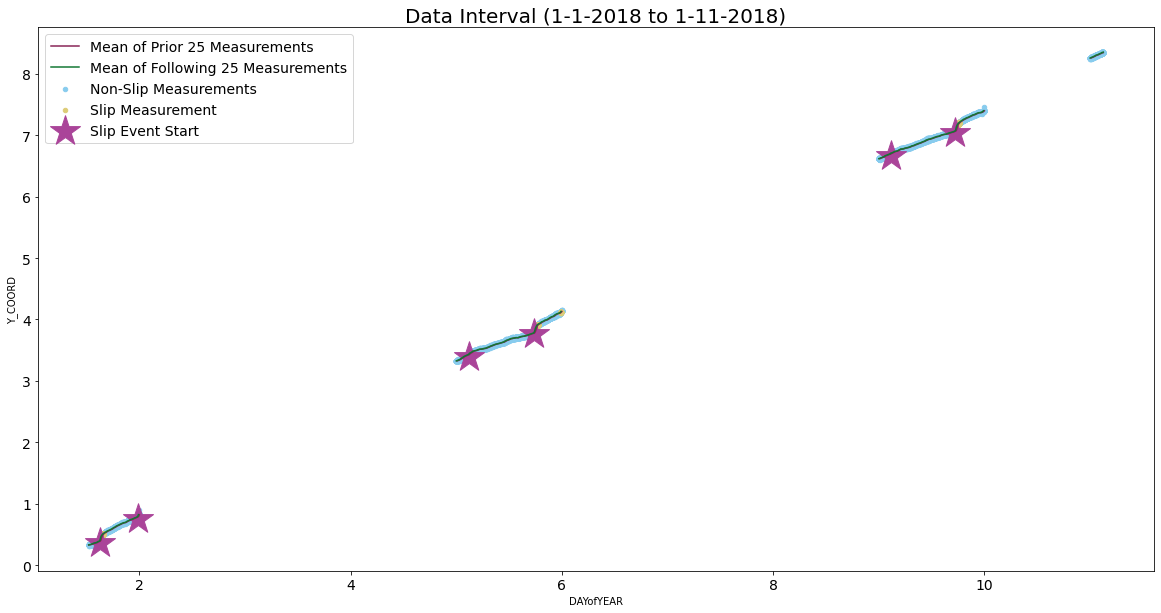

In [47]:
plotAnalysis(dataframe = LA02_Events, plotMin=3000, xInterval=15000, save=True, saveName=statList[0]+'\\Comparison1.jpg')

In [48]:
#If a station has not been combined into a cumulative file USE THIS:
#LA16 = CombineStationFiles(statList[1], save=True)

#If a cumulative file has been generated for the desired station USE THIS FILE:
LA16 = pd.read_csv('.\\la16\\Cumulative.csv'); LA16 = LA16.drop(['Unnamed: 0'], axis=1)


LA16.head()

,YEAR,MM,DD,DAYofYEAR,LATDD,LATMN,LATSS,LONDD,LONMN,LONSS,HGT(m)
0,2014,1,28,28.077257,-84,31,58.90946,-159,54,41.32663,85.4360
1,2014,1,28,28.077431,-84,31,58.91858,-159,54,41.37338,85.6653
2,2014,1,28,28.077604,-84,31,58.91870,-159,54,41.37491,85.6435
3,2014,1,28,28.077778,-84,31,58.91876,-159,54,41.37251,85.6258
4,2014,1,28,28.077951,-84,31,58.91858,-159,54,41.37267,85.6076


In [51]:
#If the data has not been analyzed yet:
#LA16 = CalculateDistance(LA16, save=True, stationPath=statList[1])

#If station has already been analyzed, import saved csv:
LA16 = pd.read_csv(statList[1]+'\\Calculated.csv'); LA16 = LA16.drop(['Unnamed: 0'], axis=1)

LA16.head()

,YEAR,MM,DD,DAYofYEAR,LATDD,LATMN,LATSS,LONDD,LONMN,LONSS,HGT(m),LAT_DEG,LON_DEG,TOT_DIST
0,2014,1,28,28.077257,-84,31,58.90946,-159,54,41.32663,85.4360,-83.466970,-158.088520,0.000000
1,2014,1,28,28.077431,-84,31,58.91858,-159,54,41.37338,85.6653,-83.466967,-158.088507,0.326103
2,2014,1,28,28.077604,-84,31,58.91870,-159,54,41.37491,85.6435,-83.466967,-158.088507,0.332025
3,2014,1,28,28.077778,-84,31,58.91876,-159,54,41.37251,85.6258,-83.466967,-158.088508,0.329410
4,2014,1,28,28.077951,-84,31,58.91858,-159,54,41.37267,85.6076,-83.466967,-158.088508,0.324853


In [53]:
#If the data has not been analyzed yet:
#LA16_Events = DetectEvents(LA16, save=True, stationPath=statList[1])

#If station has already been analyzed, import saved csv:
LA16_Events = pd.read_csv(statList[1]+'\\Detected.csv'); LA16_Events = LA16_Events.drop(['Unnamed: 0'], axis=1)


#Display first 5 rows of the analyzed dataframe
LA16_Events.head()

,YEAR,MM,DD,DAYofYEAR,LATDD,LATMN,LATSS,LONDD,LONMN,LONSS,HGT(m),LAT_DEG,LON_DEG,TOT_DIST,MEAN_50_BEFORE,MEAN_50_AFTER,INT_DIFF,SLIP_EVENT,SLIP_BEGIN
0,2014,1,28,28.077257,-84,31,58.90946,-159,54,41.32663,85.4360,-83.466970,-158.088520,NaN,NaN,NaN,NaN,False,False
1,2014,1,28,28.077431,-84,31,58.91858,-159,54,41.37338,85.6653,-83.466967,-158.088507,0.326103,NaN,0.326694,NaN,False,False
2,2014,1,28,28.077604,-84,31,58.91870,-159,54,41.37491,85.6435,-83.466967,-158.088507,0.332025,NaN,0.326799,NaN,False,False
3,2014,1,28,28.077778,-84,31,58.91876,-159,54,41.37251,85.6258,-83.466967,-158.088508,0.329410,NaN,0.326718,NaN,False,False
4,2014,1,28,28.077951,-84,31,58.91858,-159,54,41.37267,85.6076,-83.466967,-158.088508,0.324853,NaN,0.326952,NaN,False,False


In [35]:
LA02_Events.loc[LA02_Events['SLIP_BEGIN'] == True]

,YEAR,MM,DD,DAYofYEAR,LATDD,LATMN,LATSS,LONDD,LONMN,LONSS,HGT(m),LAT_DEG,LON_DEG,TOT_DIST,MEAN_50_BEFORE,MEAN_50_AFTER,INT_DIFF,SLIP_EVENT,SLIP_BEGIN
784,2018,1,1,1.136111,-84,38,16.33409,-150,16,37.75347,118.1531,-83.362129,-149.722846,0.091624,0.090666,0.105835,0.015168,True,True
3612,2018,1,1,1.627083,-84,38,16.33300,-150,16,37.83700,118.1625,-83.362130,-149.722823,0.391647,0.389161,0.404283,0.015122,True,True
5683,2018,1,1,1.986632,-84,38,16.33229,-150,16,37.94748,118.1831,-83.362130,-149.722792,0.786524,0.784442,0.800066,0.015624,True,True
6464,2018,1,5,5.122222,-84,38,16.32784,-150,16,38.68483,118.2475,-83.362131,-149.722588,3.422549,3.427695,3.443172,0.015477,True,True
10016,2018,1,5,5.738889,-84,38,16.32623,-150,16,38.78729,118.2117,-83.362132,-149.722559,3.790745,3.778802,3.793979,0.015177,True,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
264288,2018,12,24,358.772917,-84,38,15.77998,-150,17,57.51153,116.1237,-83.362283,-149.700691,285.370250,285.367371,285.382421,0.015050,True,True
267437,2018,12,27,361.319618,-84,38,15.77633,-150,17,58.07286,115.9770,-83.362284,-149.700535,287.377531,287.372065,287.387183,0.015118,True,True
269734,2018,12,27,361.718403,-84,38,15.77615,-150,17,58.16003,116.0378,-83.362284,-149.700511,287.688531,287.680116,287.695130,0.015014,True,True
271693,2018,12,31,365.058507,-84,38,15.77163,-150,17,58.89300,115.9568,-83.362286,-149.700308,290.309132,290.303308,290.318354,0.015047,True,True


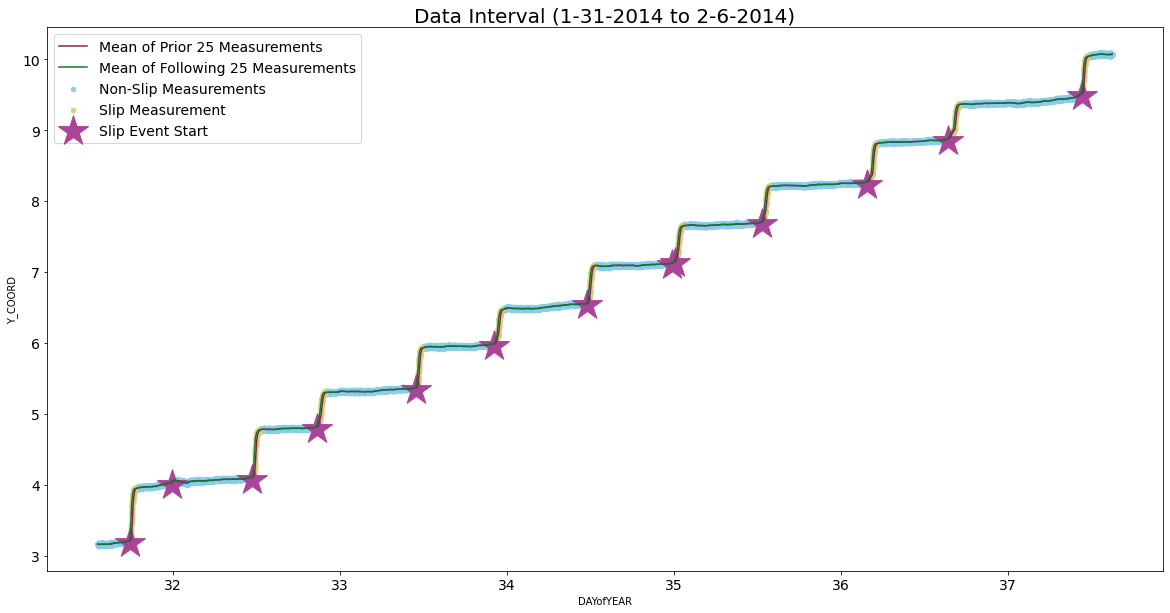

In [55]:
plotAnalysis(dataframe = LA16_Events, plotMin=20000, xInterval=35000, save=True, saveName = statList[1]+'\\Comparison1.jpg')

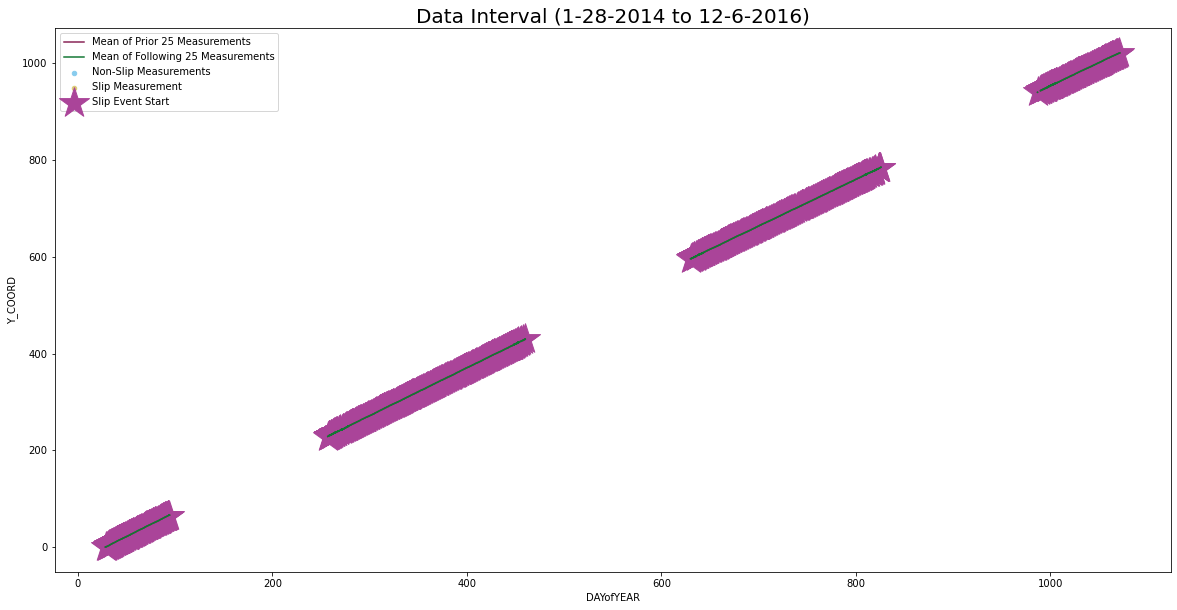

In [28]:
plotAnalysis(dataframe = LA16_Events, plotMin=0, xInterval=2950000)